# **Masterclass: AutoMl y Ensamblajes de Modelos**

In [1]:
%%capture
%pip install -q pandas==2.2.2 lightgbm==4.5.0 catboost==1.2.7 xgboost==2.1.3 optuna==4.1.0 shap==0.46.0 cloudpickle==3.0.0 pyarrow==17.0.0 scikit-learn==1.5.2 scipy==1.10.1 dask-expr==2.0.0 dask
%pip install -q setuptools==75.6.0 wheel==0.42.0 autogluon==1.2 ipywidgets==8.1.5
%pip install -q autogluon.eda==0.8.3 
%pip install -q requests==2.31.0 tabulate==0.9.0 future==1.0.0
%pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [100]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm 
import sys
import warnings
import os
import gc

# Autogluon imports
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.eda.auto as auto

# H2O imports
import h2o
from h2o.automl import H2OAutoML

# Relevant Imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

# Seteo de plotly para gráficos
pd.options.plotting.backend = "plotly"
pio.templates.default = "simple_white"
warnings.filterwarnings('ignore')

tqdm.pandas(leave = False)

# **Data**

In [33]:
train = pd.read_csv('Data/train.csv').set_index("id")
test = pd.read_csv('Data/test.csv').set_index("id")
features = train.columns.drop('y')
train.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
id,,,,,,,,,,,,,,,,,,,,,
0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,3841.0,...,1,6,14,6,6,1,1,10,2,1
1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,6,11,1,6,1,4,4,1,13,0
2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,1,4,21,12,1,16,10,4,9,0
3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,13,12,2,4,2,7,1,2,11,1
4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,12,2,2,4,1,3,1,11,15,1


In [4]:
# Basic EDA
print("\nTrain Dataset Shape:", train.shape)
print("\nTest Dataset Shape:", test.shape)

print("\nColumns in the dataset:")
print(train.columns)

print("\nMissing values in Train:")
print(train.isnull().sum()[train.isnull().sum() > 0])



Train Dataset Shape: (592380, 27)

Test Dataset Shape: (191859, 26)

Columns in the dataset:
Index(['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty',
       'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4',
       'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol',
       'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol',
       'ask4vol', 'ask5vol', 'y'],
      dtype='object')

Missing values in Train:
opened_position_qty     172460
closed_position_qty     172460
dtype: int64


# **AutoEDA Autogluon**

## **Overview**

**`train_data` dataset summary (sample size: 10000)**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
ask1,10000,3965.821500,81.644086,3814.8,3896.6,3984.2,4040.20,4114.6,float64,1264,,,float,numeric,
ask1vol,10000,3.905900,4.576979,1.0,1.0,2.0,5.00,74.0,int64,47,,,int,numeric,
ask2,10000,3966.059640,81.650049,3815.0,3896.8,3984.4,4040.45,4114.8,float64,1256,,,float,numeric,
ask2vol,10000,4.890900,5.529906,1.0,2.0,3.0,6.00,106.0,int64,54,,,int,numeric,
ask3,10000,3966.284960,81.655701,3815.2,3897.0,3984.6,4040.80,4115.0,float64,1251,,,float,numeric,
ask3vol,10000,5.300800,6.092785,1.0,2.0,4.0,6.00,93.0,int64,67,,,int,numeric,
ask4,10000,3966.508600,81.662901,3815.4,3897.2,3984.8,4041.00,4115.4,float64,1252,,,float,numeric,
ask4vol,10000,5.595400,6.442348,1.0,2.0,4.0,7.00,127.0,int64,67,,,int,numeric,
ask5,10000,3966.729240,81.669544,3815.6,3897.4,3985.0,4041.20,4115.6,float64,1250,,,float,numeric,
ask5vol,10000,5.924900,7.016993,1.0,2.0,4.0,7.00,134.0,int64,65,,,int,numeric,


**`test_data` dataset summary (sample size: 10000)**

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,variable_type,special_types
ask1,10000,5181.391780,46.402012,5070.2,5149.0,5175.8,5223.8,5277.4,float64,978,,,float,numeric,
ask1vol,10000,3.010300,4.010786,1.0,1.0,2.0,3.0,78.0,int64,47,,,int,numeric,
ask2,10000,5181.717520,46.407405,5070.4,5149.2,5176.2,5224.2,5277.6,float64,970,,,float,numeric,
ask2vol,10000,3.340700,4.533815,1.0,1.0,2.0,4.0,92.0,int64,48,,,int,numeric,
ask3,10000,5182.018160,46.414888,5070.6,5149.6,5176.4,5224.6,5277.8,float64,970,,,float,numeric,
ask3vol,10000,3.552800,4.926037,1.0,1.0,2.0,4.0,92.0,int64,55,,,int,numeric,
ask4,10000,5182.313580,46.420737,5071.0,5149.8,5176.8,5224.8,5278.0,float64,970,,,float,numeric,
ask4vol,10000,3.800100,5.232731,1.0,1.0,2.0,4.0,98.0,int64,57,,,int,numeric,
ask5,10000,5182.606560,46.428238,5071.4,5150.0,5177.0,5225.0,5278.6,float64,975,,,float,numeric,
ask5vol,10000,4.020100,6.182242,1.0,1.0,2.0,4.0,103.0,int64,68,,,int,numeric,


**Types warnings summary**

,train_data,test_data,warnings
y,int,--,warning


### Feature Distance

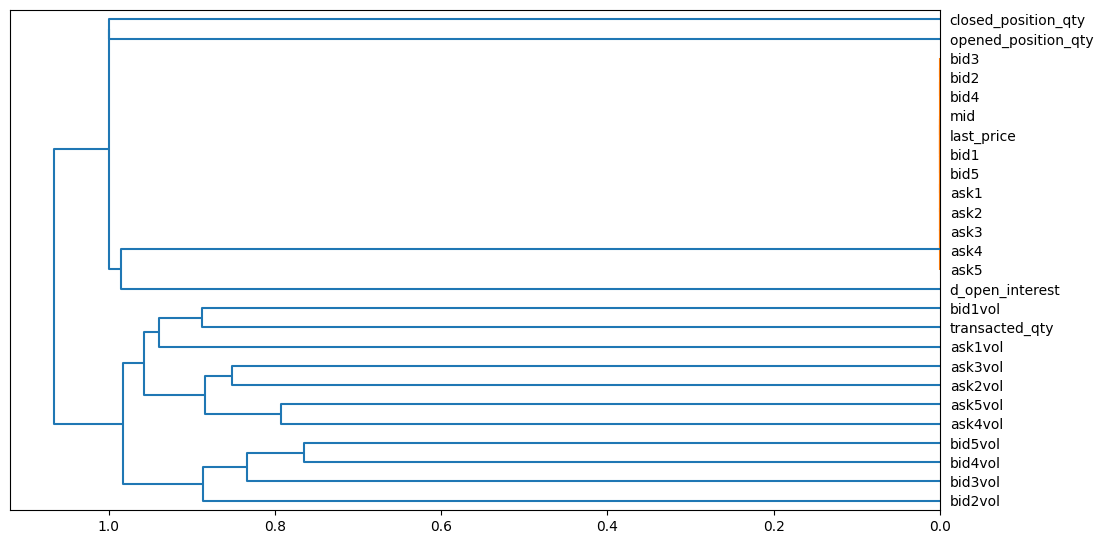

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `ask1`, `ask2`, `ask3`, `ask4`, `ask5`, `bid1`, `bid2`, `bid3`, `bid4`, `bid5`, `last_price`, `mid` - distance `0.00`

Feature interaction between `ask1`/`ask2`

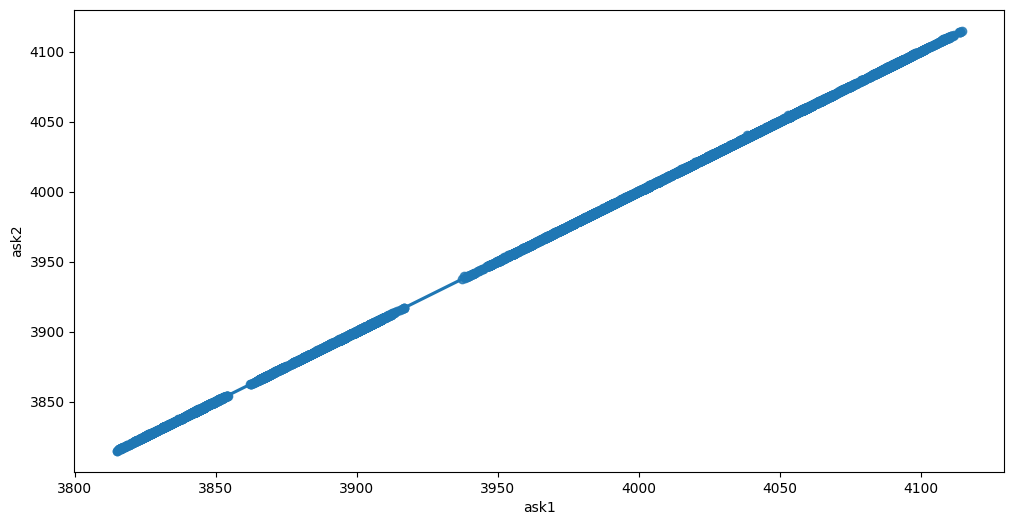

Feature interaction between `ask1`/`ask3`

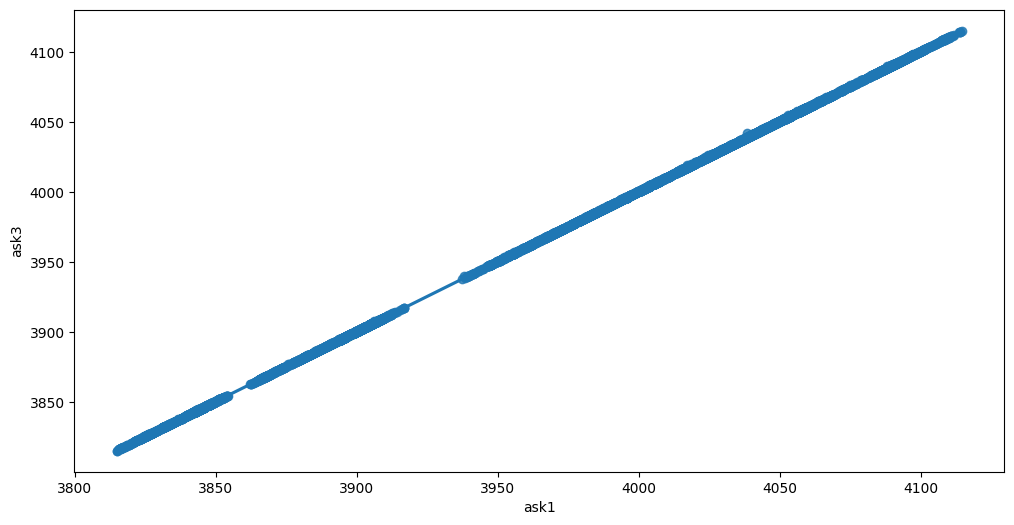

Feature interaction between `ask1`/`ask4`

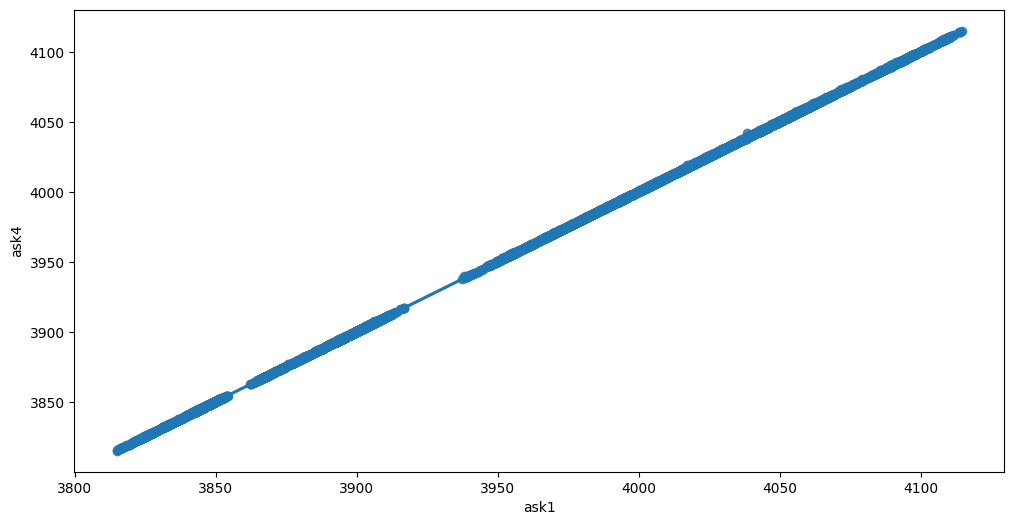

Feature interaction between `ask1`/`ask5`

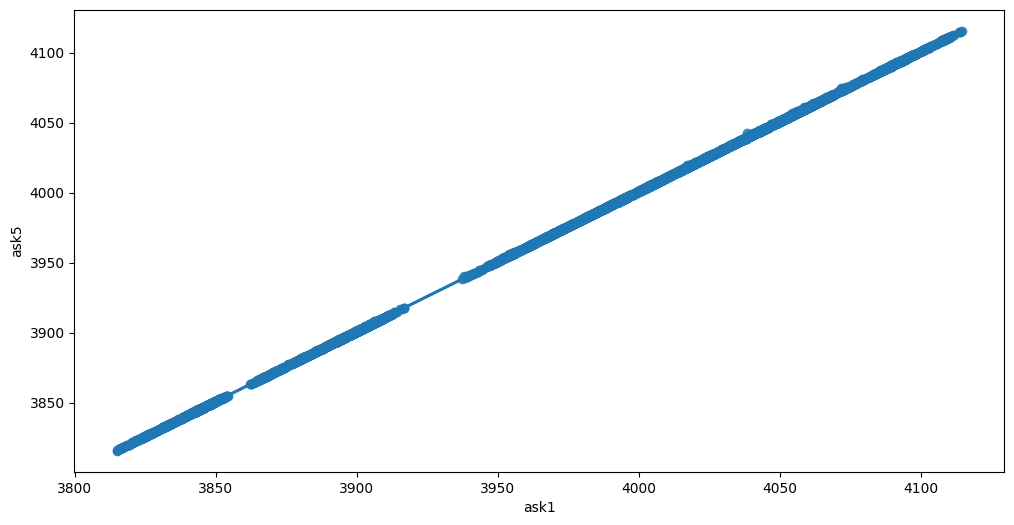

Feature interaction between `ask1`/`bid1`

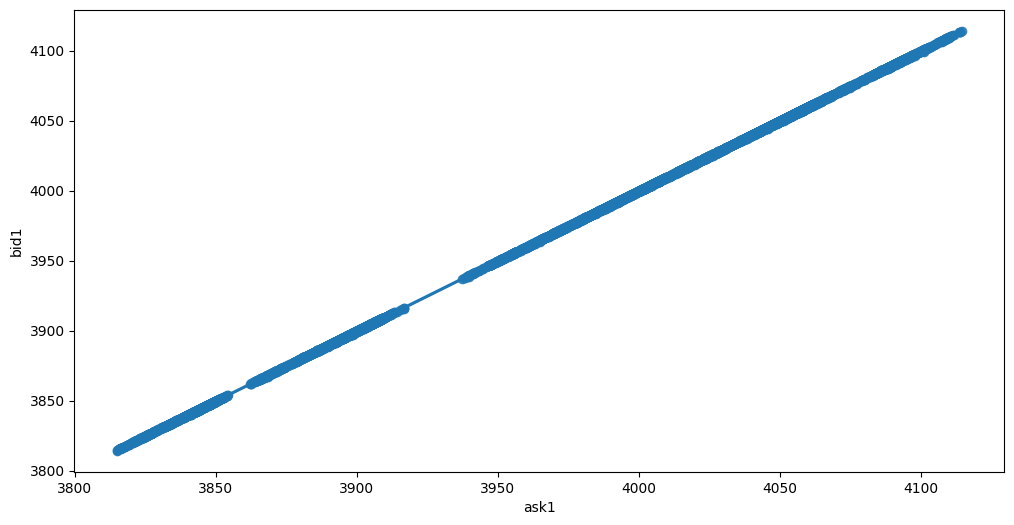

Feature interaction between `ask1`/`bid2`

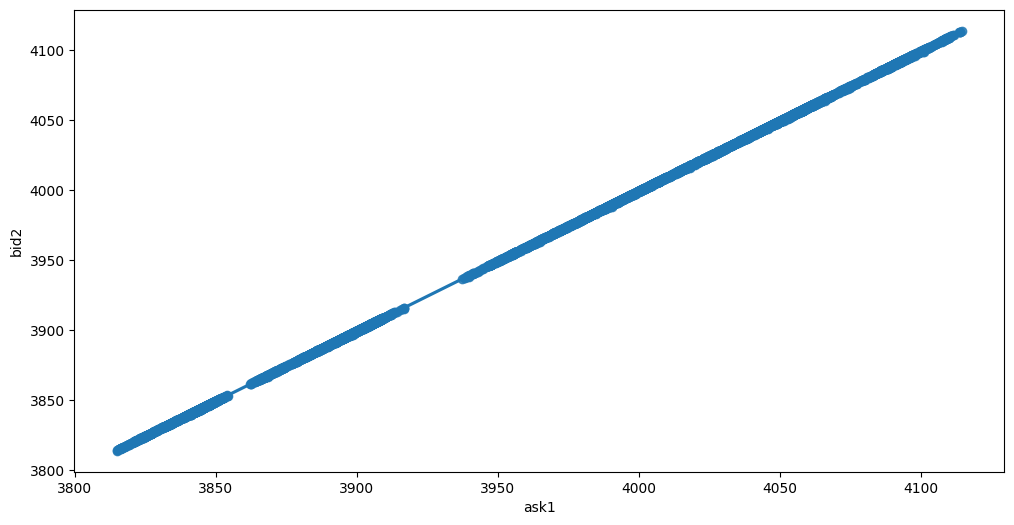

Feature interaction between `ask1`/`bid3`

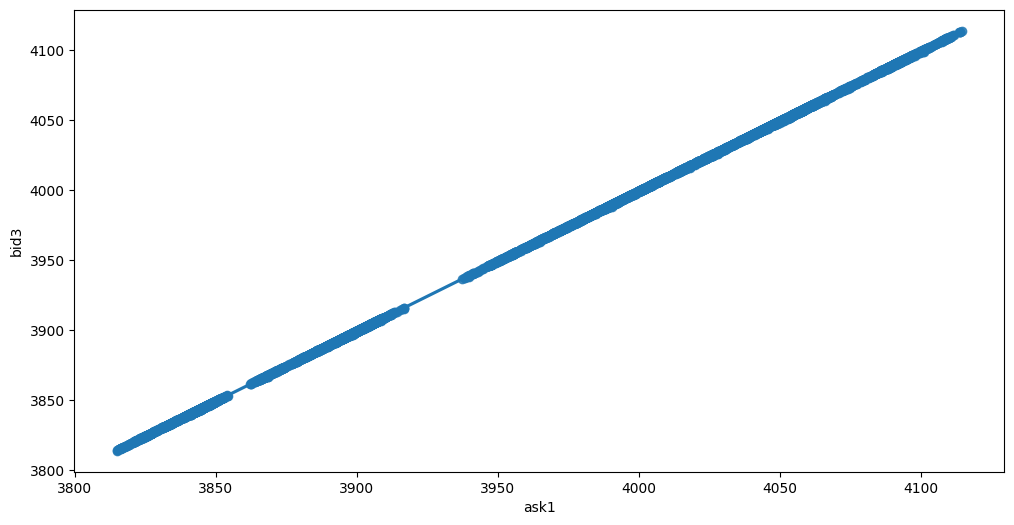

Feature interaction between `ask1`/`bid4`

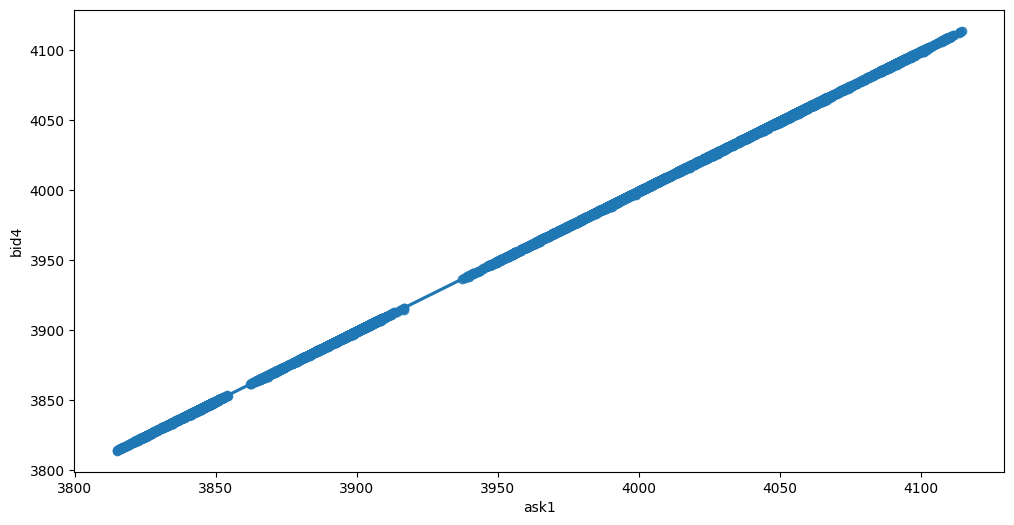

Feature interaction between `ask1`/`bid5`

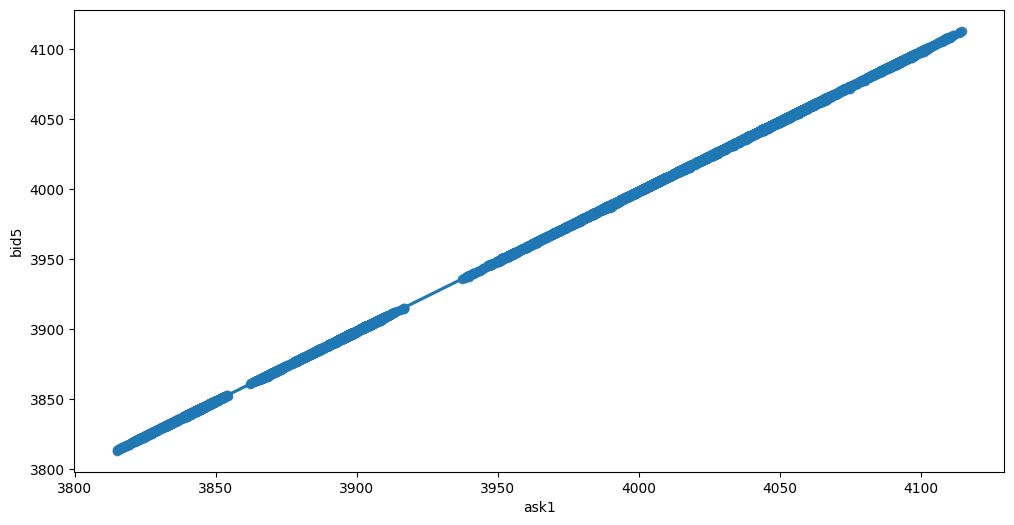

Feature interaction between `ask1`/`last_price`

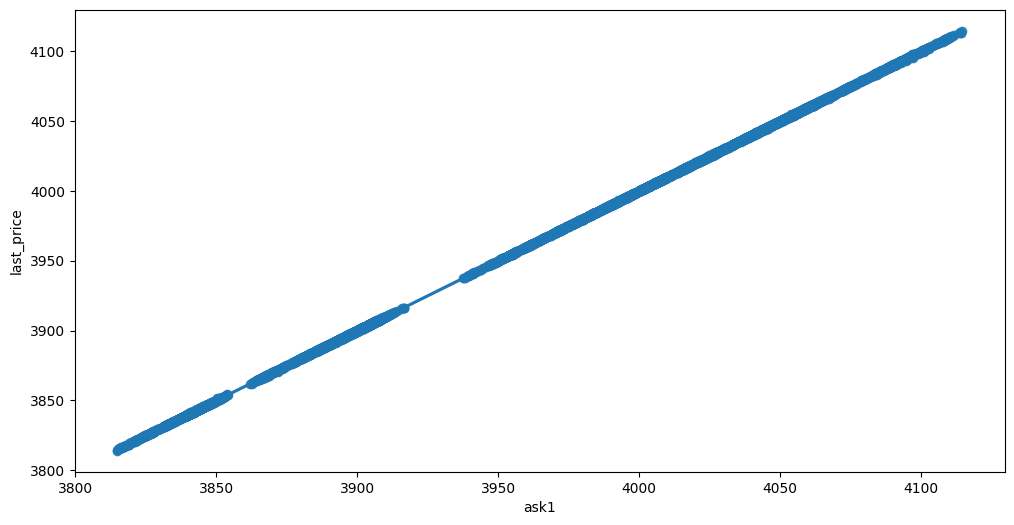

Feature interaction between `ask1`/`mid`

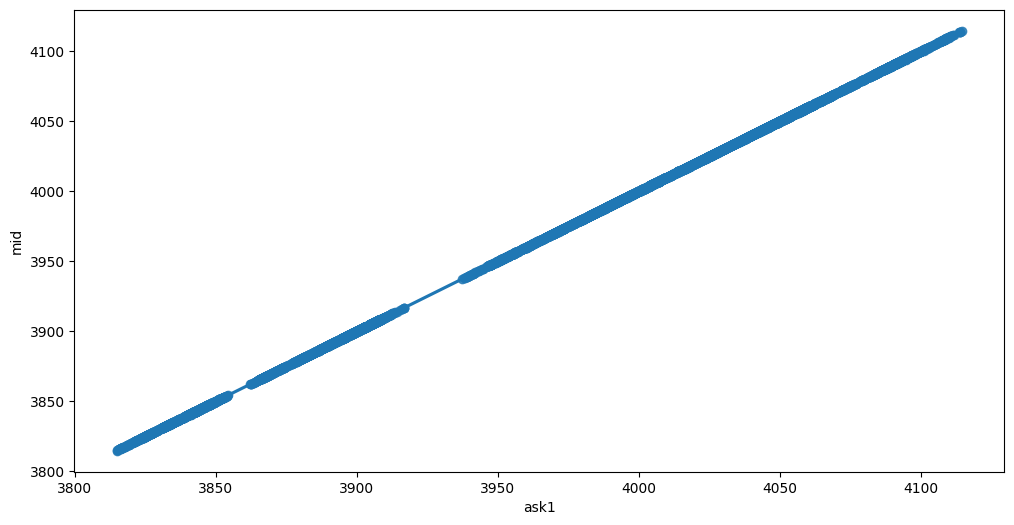

In [5]:
auto.dataset_overview(train_data=train, test_data=test, label='y')

## **Análisis de target**

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,0.37,0.482828,0.0,0.0,0.0,1.0,1.0,int64,2,,,int,


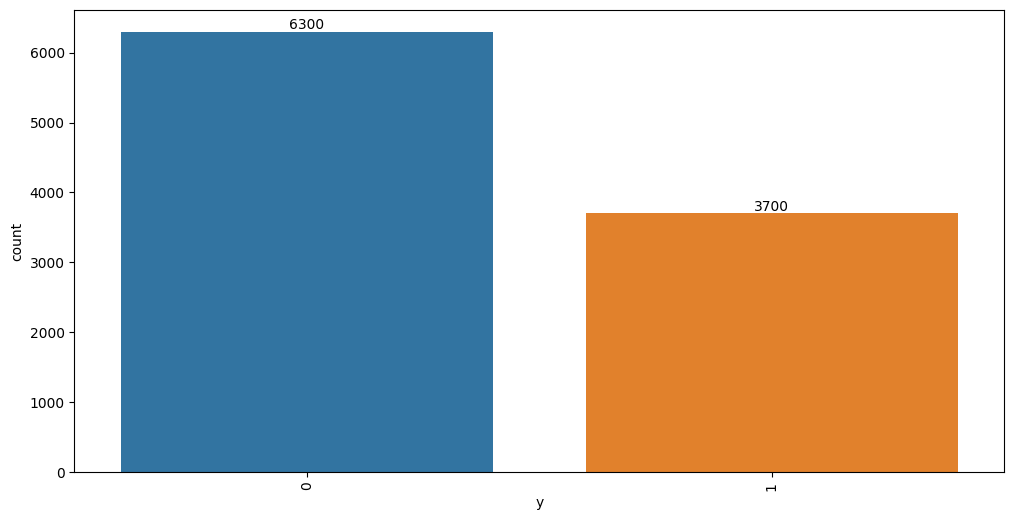

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `y`.

In [6]:
auto.target_analysis(train_data=train, label='y', )

## **Quickfit**

No path specified. Models will be saved in: "AutogluonModels/ag-20250225_024247/"


### Model Prediction for y

Using validation data for `Test` points

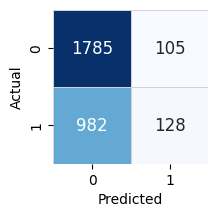

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.637667,0.645714,0.004132,0.002102,0.904963,0.004132,0.002102,0.904963,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
ask1vol,0.016467,0.001835,0.000018,5,0.020245,0.012689
bid1vol,0.004600,0.003320,0.018142,5,0.011436,-0.002236
bid3,0.001867,0.001095,0.009467,5,0.004122,-0.000389
ask2vol,0.001600,0.002241,0.092811,5,0.006214,-0.003014
opened_position_qty,0.001467,0.001835,0.074202,5,0.005245,-0.002311
ask4vol,0.001400,0.002100,0.105171,5,0.005724,-0.002924
mid,0.001400,0.001300,0.036823,5,0.004076,-0.001276
closed_position_qty,0.001267,0.002488,0.159232,5,0.006389,-0.003856
bid3vol,0.001067,0.001278,0.067706,5,0.003698,-0.001565
ask3vol,0.000733,0.001588,0.180084,5,0.004003,-0.002537


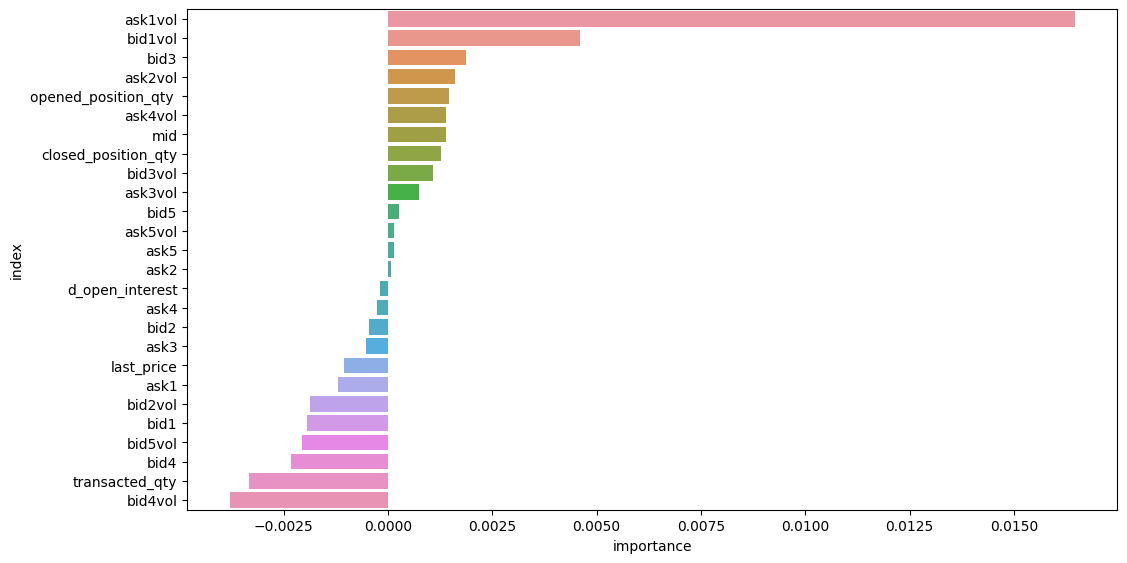

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,dataset,y,0,1,error
id,,,,,,,,,,,,,,,,,,,,,
43524,3838.0,3837.9,NaN,NaN,0.0,0,3837.6,3837.4,3837.2,3837.0,...,14,3,3,3,1,train,1,0.899431,0.100569,0.798861
85288,3882.0,3881.9,NaN,NaN,0.0,0,3881.6,3881.2,3881.0,3880.8,...,26,1,3,2,15,train,1,0.892345,0.107655,0.784691
474581,3997.0,3996.7,1.0,0.0,1.0,1,3996.4,3996.2,3996.0,3995.8,...,14,2,1,8,2,train,1,0.862619,0.137381,0.725238
38787,3829.2,3829.2,NaN,NaN,0.0,0,3829.0,3828.8,3828.6,3828.4,...,7,11,30,31,3,train,1,0.846417,0.153583,0.692834
376156,4060.0,4059.9,1.0,1.0,2.0,0,4059.6,4059.4,4059.2,4059.0,...,74,1,8,1,2,train,1,0.837659,0.162341,0.675317
230035,3908.2,3908.1,0.0,2.0,2.0,-1,3908.0,3907.8,3907.6,3907.4,...,15,7,13,17,39,train,1,0.834723,0.165277,0.669446
279622,3969.4,3969.5,0.0,1.0,1.0,0,3969.4,3969.2,3969.0,3968.8,...,14,18,32,6,12,train,1,0.832715,0.167285,0.665429
452120,4005.0,4004.8,1.0,2.0,3.0,0,4004.6,4004.4,4004.0,4003.8,...,17,1,6,3,6,train,1,0.831356,0.168644,0.662713
353979,4039.8,4039.7,0.0,1.0,1.0,-1,4039.6,4039.4,4039.2,4039.0,...,18,12,2,12,5,train,1,0.829984,0.170016,0.659967


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,dataset,y,0,1,error
id,,,,,,,,,,,,,,,,,,,,,
339962,4060.0,4060.1,1.0,1.0,2.0,0,4060.0,4059.8,4059.4,4059.2,...,2,6,5,4,4,train,0,0.499862,0.500138,0.000276
70261,3846.4,3846.3,2.0,0.0,2.0,2,3846.2,3846.0,3845.8,3845.6,...,1,1,5,9,1,train,0,0.499803,0.500197,0.000393
461769,3994.0,3993.9,2.0,4.0,6.0,-2,3993.8,3993.6,3993.4,3993.2,...,4,1,3,1,3,train,1,0.500349,0.499651,0.000699
3165,3850.2,3850.2,2.0,7.0,9.0,-5,3850.0,3849.8,3849.6,3849.4,...,1,2,1,3,3,train,0,0.499529,0.500471,0.000943
293374,3984.6,3984.7,1.0,0.0,1.0,1,3984.6,3984.0,3983.8,3983.6,...,1,8,5,7,3,train,0,0.499515,0.500485,0.000971
86093,3882.6,3882.8,1.0,2.0,3.0,-1,3882.4,3882.2,3882.0,3881.6,...,1,2,1,1,3,train,1,0.500549,0.499451,0.001098
304916,4015.4,4015.3,0.0,3.0,3.0,-2,4015.2,4015.0,4014.8,4014.6,...,2,1,12,3,1,train,1,0.500658,0.499342,0.001316
339520,4058.6,4058.5,0.0,2.0,2.0,-1,4058.2,4058.0,4057.8,4057.6,...,2,7,1,1,2,train,0,0.499250,0.500750,0.001500
116874,3889.0,3889.1,0.0,1.0,1.0,0,3889.0,3888.8,3888.6,3888.4,...,1,1,5,1,2,train,1,0.502246,0.497754,0.004493


In [28]:
qfit = auto.quick_fit(train, 'y', show_feature_importance_barplots=True)

## **Covariate Shift Analysis**

We detected a substantial difference between the training and test X distributions,
a type of distribution shift.

**Test results**: We can predict whether a sample is in the test vs. training set with a `roc_auc` of
`1.0000` with a p-value of `0.0010` (smaller than the threshold of `0.0100)`.



**Feature importances**: The variables that are the most responsible for this shift are those with high feature importance:



,importance,stddev,p_value,n,p99_high,p99_low
last_price,1.728075e-06,3.078272e-07,0.000116,5,0.000002,1.094254e-06
ask5,1.376066e-06,4.746992e-07,0.001460,5,0.000002,3.986541e-07
ask2,1.152047e-06,3.468912e-07,0.000878,5,0.000002,4.377933e-07
ask3,7.360335e-07,3.853567e-07,0.006470,5,0.000002,-5.742129e-08
ask5vol,7.360222e-07,4.323060e-07,0.009494,5,0.000002,-1.541018e-07


**`last_price` values distribution between datasets; p-value: `0.0001`**

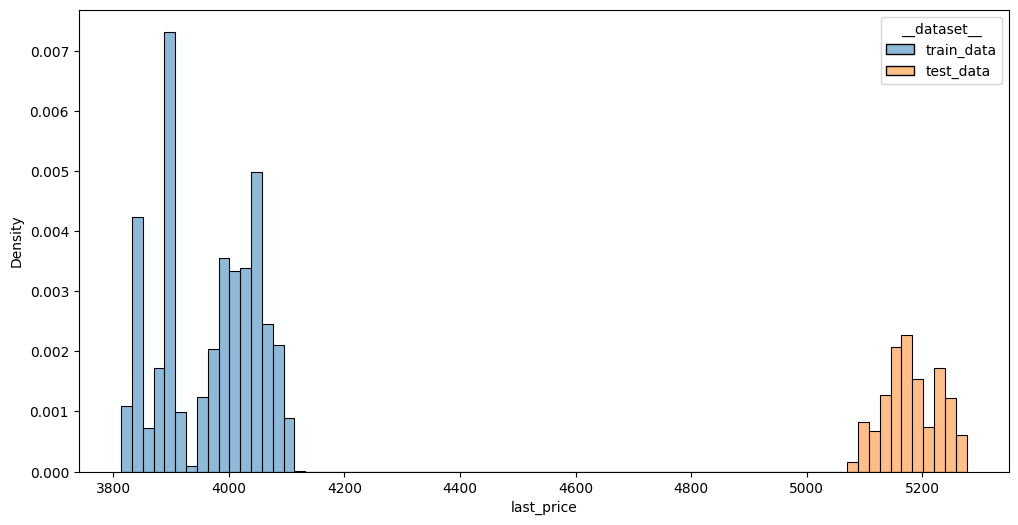

**`ask5` values distribution between datasets; p-value: `0.0015`**

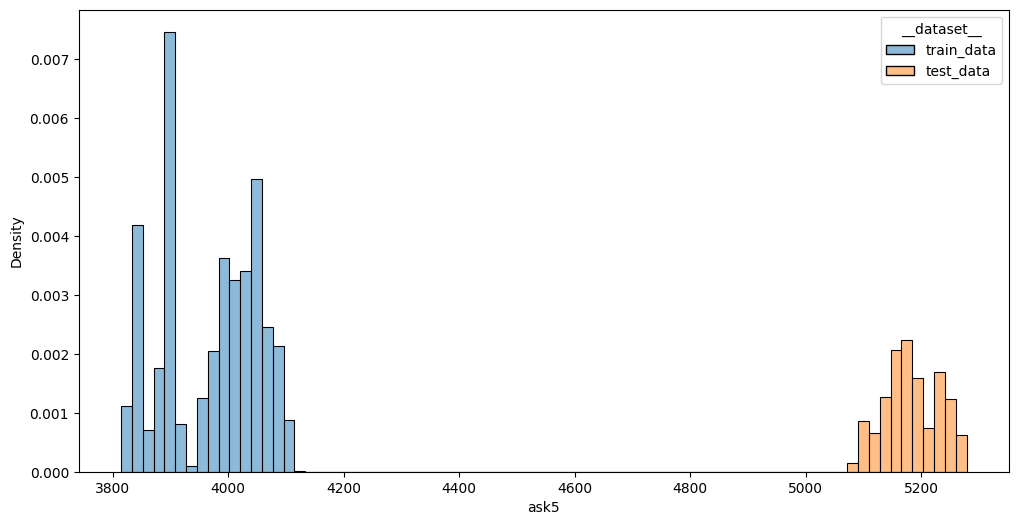

**`ask2` values distribution between datasets; p-value: `0.0009`**

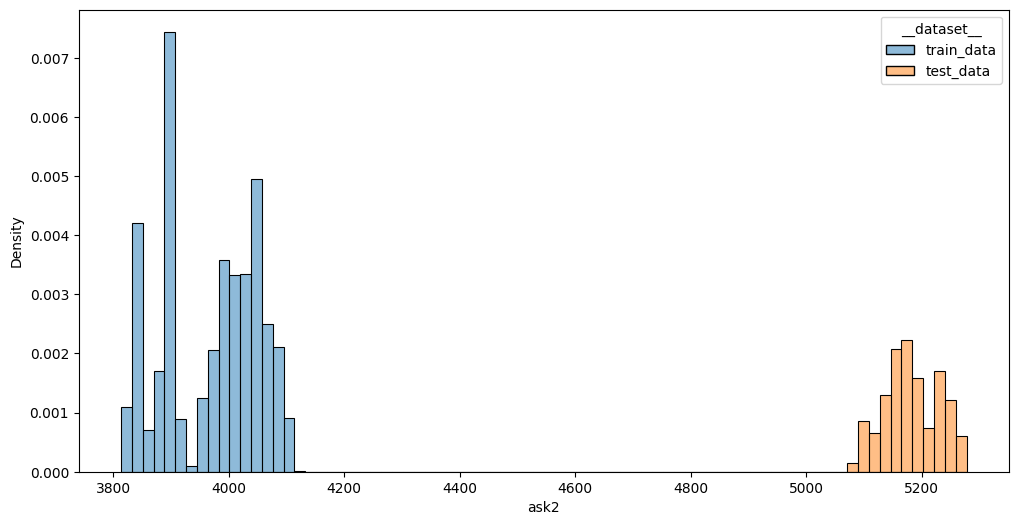

**`ask3` values distribution between datasets; p-value: `0.0065`**

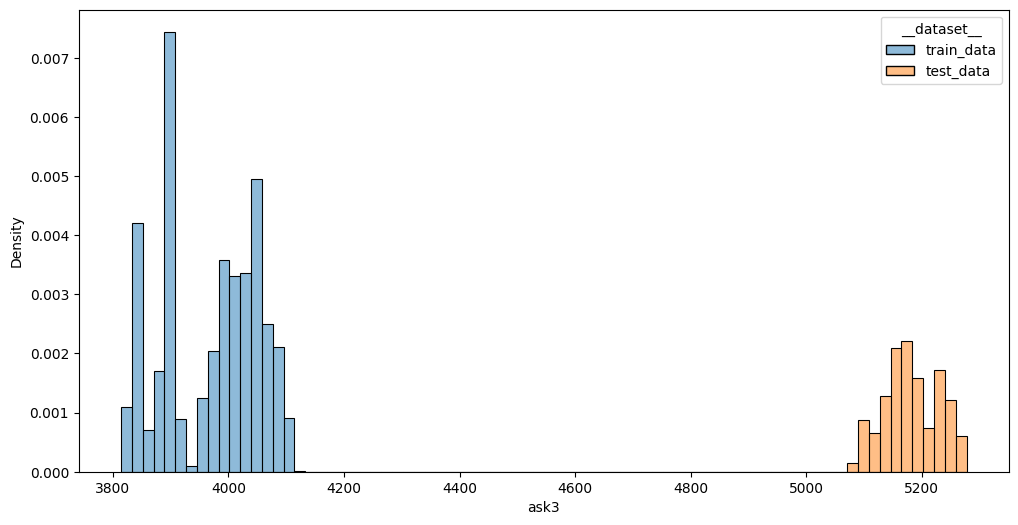

**`ask5vol` values distribution between datasets; p-value: `0.0095`**

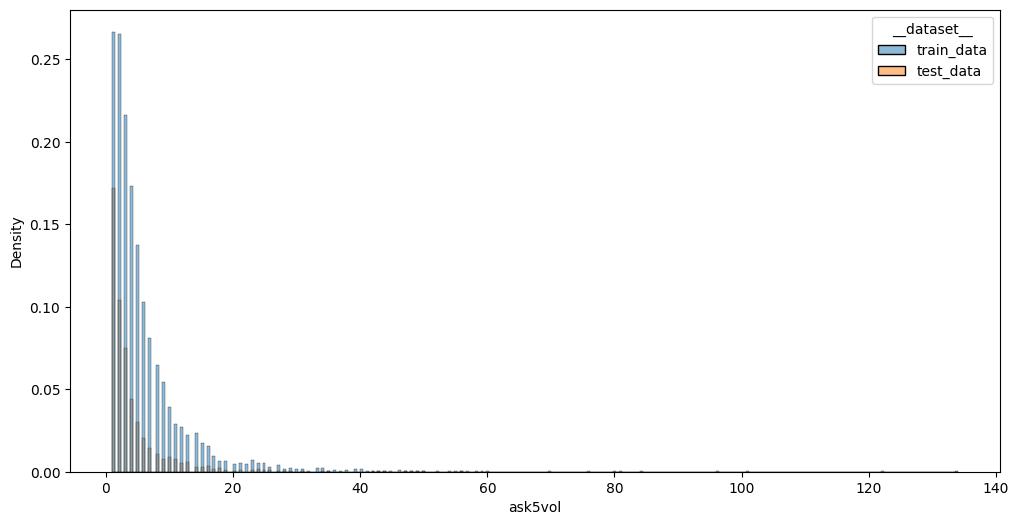

In [8]:
auto.covariate_shift_detection(train_data=train, test_data=test, label='y')    

## **Missing Values**

### Missing Values Analysis

,missing_count,missing_ratio
opened_position_qty,2898,0.2898
closed_position_qty,2898,0.2898


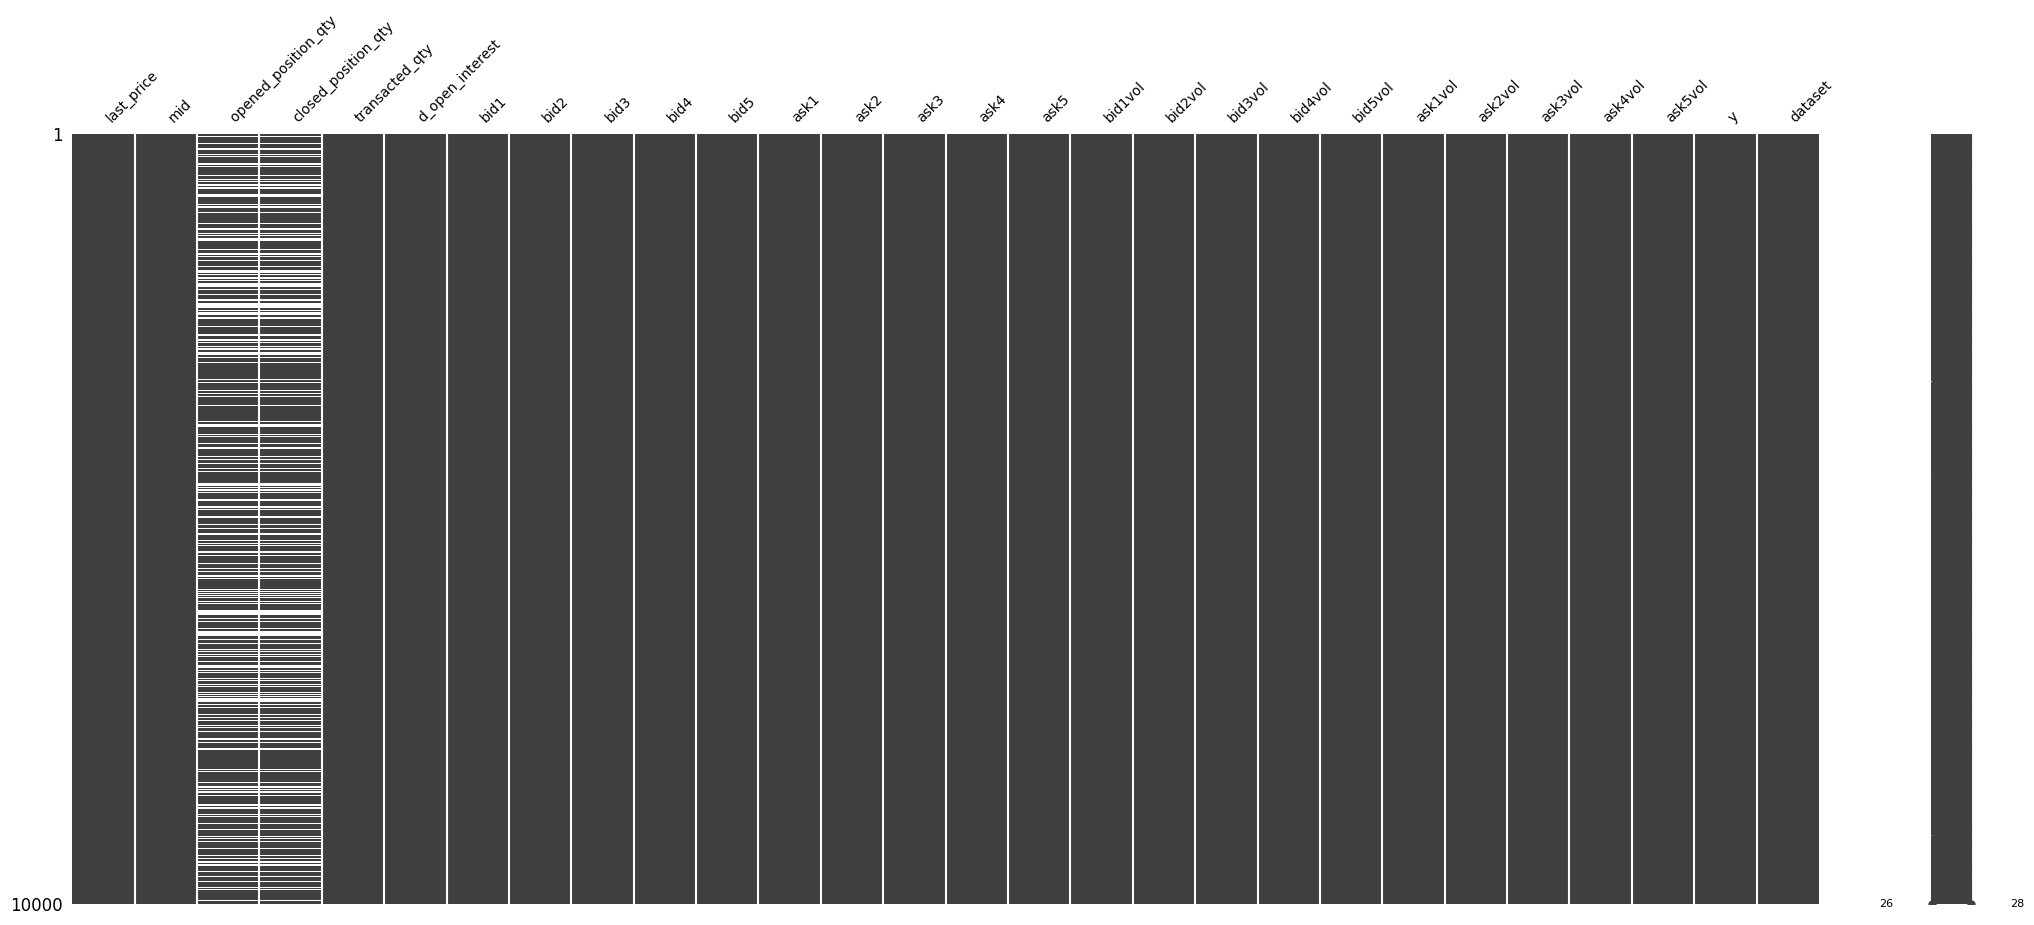

In [21]:
auto.missing_values_analysis(train_data=train)

## **Interaction Analysis**

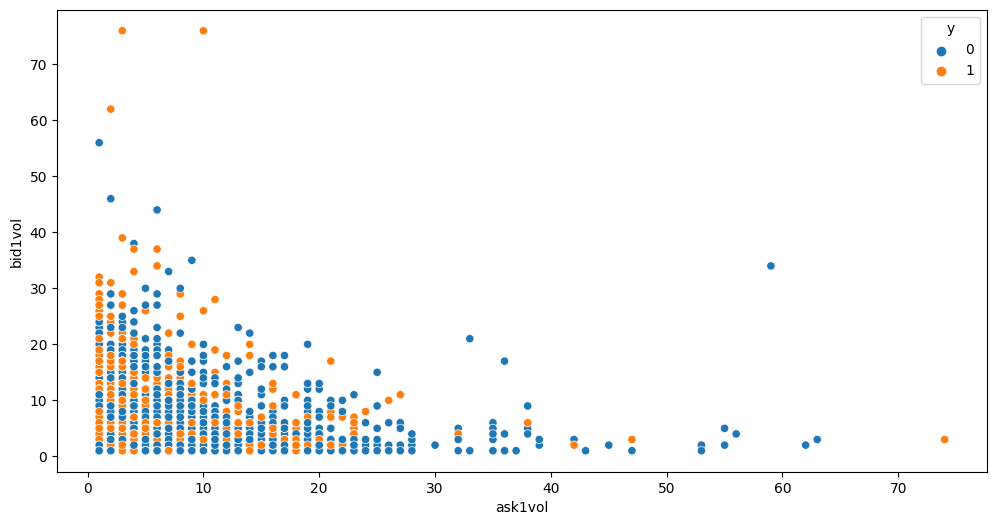

In [27]:
auto.analyze_interaction(train_data=train, x='ask1vol', y='bid1vol', hue='y')

# **Benchmark Models**

In [ ]:
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
}

# Prepare data
X = train[features]
y = train['y']

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name} CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Convert results to long format for ggplot
results_df = pd.DataFrame(results)
results_long = results_df.melt(var_name='Model', value_name='AUC')

Training RandomForest...
RandomForest CV accuracy: 0.6404 ± 0.0018
Training XGBoost...
XGBoost CV accuracy: 0.6441 ± 0.0011
Training CatBoost...
CatBoost CV accuracy: 0.6470 ± 0.0013
Training LightGBM...
LightGBM CV accuracy: 0.6434 ± 0.0013


In [44]:
# Plot results using plotly
fig = px.box(results_long, x='Model', y='AUC', 
             title='Model Performance Comparison (5-fold CV)',
             color='Model', 
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    xaxis_title='',
    yaxis_title='AUC',
    title_font=dict(size=14, family='Arial, bold'),
    xaxis_tickfont=dict(size=12),
    template='plotly_white'
)

fig.show()

# **H2O AutoML**

In [45]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_421"; Java(TM) SE Runtime Environment (build 1.8.0_421-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/mv/dc1zj8q116s9fq6jrlqb43040000gn/T/tmpml4oa0eb
  JVM stdout: /var/folders/mv/dc1zj8q116s9fq6jrlqb43040000gn/T/tmpml4oa0eb/h2o_flreyes_started_from_python.out
  JVM stderr: /var/folders/mv/dc1zj8q116s9fq6jrlqb43040000gn/T/tmpml4oa0eb/h2o_flreyes_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 22 days
H2O_cluster_name:,H2O_from_python_flreyes_oq2gwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [87]:
# Load data into H2O frames
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test[features])

# Define features and target
y = 'y'  # Target column
x = features.tolist()

# For binary classification, response should be a factor
train_h2o[y] = train_h2o[y].asfactor()

# Run AutoML
aml = H2OAutoML(max_models=20, 
                seed=42,
                max_runtime_secs=60*60,  # 60 minutes
                nfolds=5,
                sort_metric='AUC',
                keep_cross_validation_predictions=True)
                
aml.train(x=x, y=y, training_frame=train_h2o)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
07:41:56.600: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [56]:
# Get leaderboard
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_2_20250225_00923,0.660829,0.614622,0.49664,0.403772,0.461704,0.21317
StackedEnsemble_AllModels_1_AutoML_2_20250225_00923,0.660681,0.614558,0.497217,0.403186,0.461673,0.213142
GBM_grid_1_AutoML_2_20250225_00923_model_3,0.653243,0.618797,0.486974,0.405321,0.463672,0.214992
XRT_1_AutoML_2_20250225_00923,0.651041,0.619883,0.48647,0.410167,0.464099,0.215388
DRF_1_AutoML_2_20250225_00923,0.650039,0.62011,0.484654,0.410029,0.464204,0.215485
GBM_1_AutoML_2_20250225_00923,0.645353,0.621231,0.483207,0.415579,0.46476,0.216002
GBM_4_AutoML_2_20250225_00923,0.645076,0.621468,0.482098,0.416828,0.464854,0.216089
GBM_grid_1_AutoML_2_20250225_00923_model_5,0.644593,0.621677,0.482066,0.415555,0.464937,0.216166
GBM_3_AutoML_2_20250225_00923,0.643829,0.622002,0.481559,0.419504,0.465082,0.216301
GBM_2_AutoML_2_20250225_00923,0.64313,0.622353,0.480283,0.418445,0.465243,0.216451


In [99]:
h2o_cv_results = [0.6611171,	0.6623833,	0.6605365,	0.6611391,	0.6591138]
results_long_h2o = results_long.append(pd.DataFrame({'Model': 'H2O AutoML', 'AUC': h2o_cv_results}))

# Plot results using plotly
fig = px.box(results_long_h2o, x='Model', y='AUC', 
             title='Model Performance Comparison (5-fold CV)',
             color='Model', 
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    xaxis_title='',
    yaxis_title='AUC',
    title_font=dict(size=14, family='Arial, bold'),
    xaxis_tickfont=dict(size=12),
    template='plotly_white'
)

fig.show()

# **Autogluon**

In [58]:
# Setting up
eval_metric = 'roc_auc'
label = 'y'
problem_type='binary'
hours = 1

# Initialize the TabularPredictor
predictor = TabularPredictor(label=label, eval_metric=eval_metric, problem_type=problem_type,
                             path = "AutogluonModels/masterclass_example")
                
# Fit the model
predictor.fit(train_data=train,
              time_limit=3600*hours,
              presets="best_quality")

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/masterclass_example/"
AutoGluon Version:  0.8.3
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:43:05 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6020
Disk Space Avail:   227.58 GB / 494.38 GB (46.0%)
Train Data Rows:    592380
Train Data Columns: 26
Label Column: y
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4484.73 MB
	Train Data (Original)  Memory Usage: 123.22 MB (2.7% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify

[1000]	valid_set's binary_logloss: 0.622359
[2000]	valid_set's binary_logloss: 0.622182
[1000]	valid_set's binary_logloss: 0.62374
[2000]	valid_set's binary_logloss: 0.623564
[3000]	valid_set's binary_logloss: 0.623571
[1000]	valid_set's binary_logloss: 0.621704
[2000]	valid_set's binary_logloss: 0.621199
[3000]	valid_set's binary_logloss: 0.621018
[4000]	valid_set's binary_logloss: 0.620946
[5000]	valid_set's binary_logloss: 0.620882
[6000]	valid_set's binary_logloss: 0.620859
[7000]	valid_set's binary_logloss: 0.620822
[8000]	valid_set's binary_logloss: 0.620851
[1000]	valid_set's binary_logloss: 0.622256
[2000]	valid_set's binary_logloss: 0.621914
[3000]	valid_set's binary_logloss: 0.621807
[4000]	valid_set's binary_logloss: 0.621716
[5000]	valid_set's binary_logloss: 0.621782
[1000]	valid_set's binary_logloss: 0.622009
[2000]	valid_set's binary_logloss: 0.621583
[3000]	valid_set's binary_logloss: 0.621428
[4000]	valid_set's binary_logloss: 0.6214
[1000]	valid_set's binary_logloss: 

	0.6459	 = Validation score   (roc_auc)
	339.99s	 = Training   runtime
	22.0s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 3234.11s of the 3234.11s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's binary_logloss: 0.620368
[2000]	valid_set's binary_logloss: 0.618855
[3000]	valid_set's binary_logloss: 0.618176
[4000]	valid_set's binary_logloss: 0.617412
[5000]	valid_set's binary_logloss: 0.616794
[6000]	valid_set's binary_logloss: 0.616493
[7000]	valid_set's binary_logloss: 0.6163
[8000]	valid_set's binary_logloss: 0.616193
[9000]	valid_set's binary_logloss: 0.616079
[10000]	valid_set's binary_logloss: 0.61633
[1000]	valid_set's binary_logloss: 0.621916
[2000]	valid_set's binary_logloss: 0.620471
[3000]	valid_set's binary_logloss: 0.619542
[4000]	valid_set's binary_logloss: 0.618751
[5000]	valid_set's binary_logloss: 0.618077
[6000]	valid_set's binary_logloss: 0.617463
[7000]	valid_set's binary_logloss: 0.617129
[8000]	valid_set's binary_logloss: 0.617098
[9000]	valid_set's binary_logloss: 0.616973
[10000]	valid_set's binary_logloss: 0.616991
[1000]	valid_set's binary_logloss: 0.619724
[2000]	valid_set's binary_logloss: 0.61847
[3000]	valid_set's binary_logloss:

	0.6627	 = Validation score   (roc_auc)
	582.46s	 = Training   runtime
	48.81s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 2600.36s of the 2600.36s of remaining time.
	0.6553	 = Validation score   (roc_auc)
	51.17s	 = Training   runtime
	10.57s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 2538.06s of the 2538.06s of remaining time.
	0.6547	 = Validation score   (roc_auc)
	49.12s	 = Training   runtime
	9.28s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 2479.12s of the 2479.12s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9235.
	Ran out of time, early stopping on iteration 9492.
	Ran out of time, early stopping on iteration 9792.
	0.6545	 = Validation score   (roc_auc)
	2118.68s	 = Training   runtime
	0.93s	 = Validation runtime
Fitting model: ExtraTreesGi

In [60]:
leaderboard = predictor.leaderboard()

                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2   0.670346      64.497652   675.129271                0.087635          75.431054            2       True          9
1          LightGBM_BAG_L1   0.662734      48.805357   582.458450               48.805357         582.458450            1       True          2
2    ExtraTreesGini_BAG_L1   0.661401       8.336478     9.275148                8.336478           9.275148            1       True          6
3    ExtraTreesEntr_BAG_L1   0.659054       7.268182     7.964619                7.268182           7.964619            1       True          7
4  RandomForestGini_BAG_L1   0.655310      10.569725    51.167856               10.569725          51.167856            1       True          3
5  RandomForestEntr_BAG_L1   0.654685       9.275799    49.119820                9.275799          49.119820            1       True    

In [118]:
oofs_best_model = predictor.get_oof_pred_proba(model="LightGBM_BAG_L1")[1]

# Calculate AutoGluon AUC per fold
ag_scores = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for _, val_idx in cv.split(train):
    ag_scores.append(roc_auc_score(train['y'].iloc[val_idx], oofs_best_model[val_idx]))
    
# Update comparison dataframe and plot
results_long_final = pd.concat([
    results_long_h2o,
    pd.DataFrame({'Model': 'AutoGluon', 'AUC': ag_scores})
])

In [119]:
# Plot results using plotly
fig = px.box(results_long_final, x='Model', y='AUC', 
             title='Model Performance Comparison (5-fold CV)',
             color='Model', 
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    xaxis_title='',
    yaxis_title='AUC',
    title_font=dict(size=14, family='Arial, bold'),
    xaxis_tickfont=dict(size=12),
    template='plotly_white'
)

fig.show()

# **Test Predictions**

TODO: Las predicciones en la competencia están extrañas.

In [104]:
# Train benchmark models on full dataset and predict on test
X, y = train[features], train['y']
test_preds = pd.DataFrame(index=test.index)

# Train models and predict
for name, model in models.items():
    print(f"Training {name} on full dataset...")
    model.fit(X, y)
    test_preds[f'{name}_pred'] = model.predict_proba(test[features])[:, 1]

# Add predictions to test dataframe
test = pd.concat([test, test_preds], axis=1)

# Show predictions
test.iloc[:5, -4:].head()

Training RandomForest on full dataset...
Training XGBoost on full dataset...
Training CatBoost on full dataset...
Training LightGBM on full dataset...


,RandomForest_pred,XGBoost_pred,CatBoost_pred,LightGBM_pred
id,,,,
592380,0.484901,0.777890,0.738302,0.590457
592381,0.301783,0.174285,0.209179,0.278426
592382,0.375206,0.345184,0.628585,0.344696
592383,0.425631,0.603030,0.617236,0.513511
592384,0.310618,0.222190,0.242871,0.226451


In [110]:
# Predict with H2O model on test set
print("Predicting with H2O model on test set...")
h2o_preds = aml.leader.predict(test_h2o)
h2o_preds_df = h2o_preds.as_data_frame()

# Add H2O predictions to test dataframe
test['h2o_pred'] = h2o_preds_df['p1'].values  # Use values to avoid index matching

# Show updated predictions including H2O
test.iloc[:5, -5:].head()


Predicting with H2O model on test set...
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,RandomForest_pred,XGBoost_pred,CatBoost_pred,LightGBM_pred,h2o_pred
id,,,,,
592380,0.484901,0.777890,0.738302,0.590457,0.594135
592381,0.301783,0.174285,0.209179,0.278426,0.246586
592382,0.375206,0.345184,0.628585,0.344696,0.424647
592383,0.425631,0.603030,0.617236,0.513511,0.677571
592384,0.310618,0.222190,0.242871,0.226451,0.407722


In [121]:
# Predict with AutoGluon model on test set
print("Predicting with AutoGluon model on test set...")
ag_preds = predictor.predict_proba(test[features], model="LightGBM_BAG_L1")

# Add AutoGluon predictions to test dataframe
test['autogluon_pred'] = ag_preds[1].values

# Show updated predictions including AutoGluon
test.iloc[:5, -6:].head()

Predicting with AutoGluon model on test set...


,RandomForest_pred,XGBoost_pred,CatBoost_pred,LightGBM_pred,h2o_pred,autogluon_pred
id,,,,,,
592380,0.484901,0.777890,0.738302,0.590457,0.594135,0.812659
592381,0.301783,0.174285,0.209179,0.278426,0.246586,0.177903
592382,0.375206,0.345184,0.628585,0.344696,0.424647,0.615287
592383,0.425631,0.603030,0.617236,0.513511,0.677571,0.549107
592384,0.310618,0.222190,0.242871,0.226451,0.407722,0.271055


In [122]:
# Save predictions to CSV files
os.makedirs('data', exist_ok=True)

models = ['RandomForest_pred', 'XGBoost_pred', 'CatBoost_pred', 'LightGBM_pred', 'h2o_pred', 'autogluon_pred']

for model in models:
    pd.DataFrame({'id': test.index, 'predicted': test[model]}).to_csv(f'data/{model}.csv', index=False)

# # Ensemble prediction
# test['ensemble_pred'] = test[models].mean(axis=1)
# pd.DataFrame({'id': test.index, 'prediction': test['ensemble_pred']}).to_csv('data/ensemble_pred.csv', index=False)



In [116]:
test_results = pd.DataFrame({'RandomForest_test': [0.58516, 0.57676], 
              'XGBoost_test': [0.58352, 0.57492], 
              'CatBoost_test': [0.57906, 0.57091], 
              'LightGBM_test': [0.59151, 0.57867], 
              'h2o_test': [0.56235, 0.55480], 
              'autogluon_test': [0.56029, 0.55311]},
              index = ["public_lb", "private_lb"])
test_results

,RandomForest_test,XGBoost_test,CatBoost_test,LightGBM_test,h2o_test,autogluon_test
public_lb,0.58516,0.58352,0.57906,0.59151,0.56235,0.56029
private_lb,0.57676,0.57492,0.57091,0.57867,0.55480,0.55311


In [117]:
fig = go.Figure()
fig.add_trace(go.Bar(x=test_results.columns, y=test_results.loc['public_lb'], name='Public LB'))
fig.add_trace(go.Bar(x=test_results.columns, y=test_results.loc['private_lb'], name='Private LB'))
fig.update_layout(title='Model Performance', xaxis_title='Model', yaxis_title='Score')
fig.show()

test_results

,RandomForest_test,XGBoost_test,CatBoost_test,LightGBM_test,h2o_test,autogluon_test
public_lb,0.58516,0.58352,0.57906,0.59151,0.56235,0.56029
private_lb,0.57676,0.57492,0.57091,0.57867,0.55480,0.55311
